# EhV

# Package imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
# %load ../common_.py
import sys
sys.path.append("..")
from common import *

In [4]:
import copy
import pickle

In [5]:
import numpy
import scipy.stats
from scipy.cluster.hierarchy import cut_tree

from sklearn.decomposition import PCA, SparsePCA, KernelPCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, robust_scale
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn import metrics
from sklearn.preprocessing import scale, robust_scale, power_transform, normalize

import umap
import umap.plot

from matplotlib.colors import Normalize
from matplotlib.path import Path as mPath
from matplotlib.patches import Polygon

from kneed import KneeLocator

In [6]:
from ehv.core import plot_gate_zarr_channels, SelectFromCollection
from ehv import normalization

In [7]:
import shap
shap.initjs()

In [8]:
import scanpy
import anndata

# Data import

In [9]:
data_dir = Path(os.environ["VSC_DATA_VO_USER"]) / "datasets/weizmann/EhV/v2/results/scip/202202071958/"

In [10]:
df = pq.read_table(data_dir / "features.parquet").to_pandas()
cat_type = CategoricalDtype(categories=sorted(df["meta_group"].astype(int).unique()), ordered=True)
df["meta_group"] = df["meta_group"].astype(int).astype(cat_type)
df["meta_replicate"] = df["meta_replicate"].astype(int)
df = df.set_index(["meta_type", "meta_object_number", "meta_replicate", "meta_suffix", "meta_group"])
df = df[numpy.load(data_dir / "indices/columns.npy", allow_pickle=True)]
df = df.loc[numpy.load(data_dir / "indices/iso.npy", allow_pickle=True)]
df = df[df["meta_label"] != "unknown"]
df["meta_label"] = pandas.Categorical(df["meta_label"], categories=["mcp-_psba+", "mcp+_psba+", "mcp+_psba-", "mcp-_psba-"], ordered=True)
df.shape

(103775, 914)

In [11]:
selected = ["feat_bgcorr_max_DAPI", "feat_bgcorr_max_Cy5", "feat_bgcorr_max_TMR"]

In [12]:
adata = anndata.AnnData(
    df.filter(regex="feat")[selected], 
    obs=pandas.concat([df.filter(regex="meta"), df.index.to_frame()], axis=1),
    dtype=numpy.float32
)
adata.raw = adata

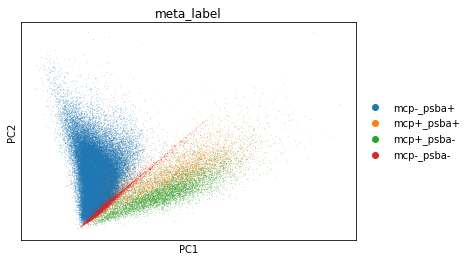

In [13]:
scanpy.pp.scale(adata)
scanpy.pp.pca(adata)
scanpy.pl.pca(adata, color=["meta_label"])

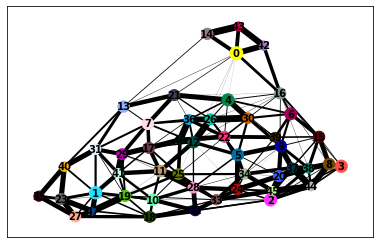

In [14]:
scanpy.pp.neighbors(adata, n_neighbors=20)

scanpy.tl.louvain(adata)

scanpy.tl.paga(adata)
scanpy.pl.paga(adata)

scanpy.tl.umap(adata, min_dist=0.1, init_pos="paga")

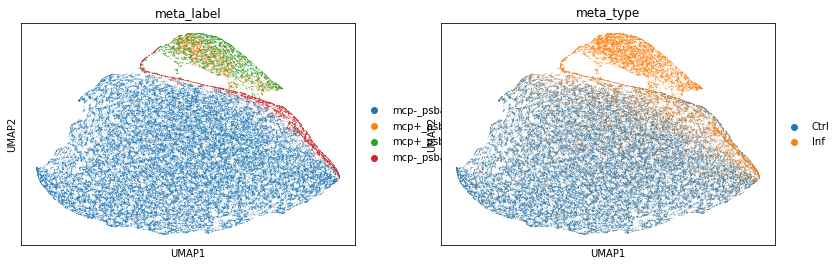

In [15]:
scanpy.pl.umap(adata, color=['meta_label', 'meta_type'])

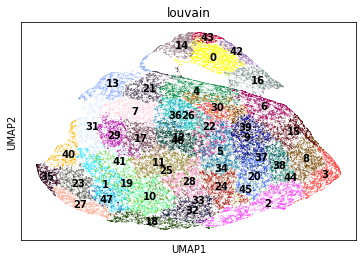

In [16]:
scanpy.pl.umap(adata, color='louvain', legend_loc='on data')